In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report

###### Presentation des données

In [ ]:
#chargement des datasets
client_train = pd.read_csv('/content/drive/MyDrive/client_train.csv')
invoice_train = pd.read_csv('/content/drive/MyDrive/invoice_train.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [ ]:
pd.set_option('display.max_columns',16)
invoice_train.head(5)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


## Analyse exploratoire des données

###### Analyse de forme 

In [ ]:
#nombres de clients different
len(client_train['client_id'].unique()), len(invoice_train['client_id'].unique())

(135493, 135493)

In [ ]:
#la target fraud 1, not fraud 0
client_train['target'].value_counts()/client_train.shape[0]*100

0.0    94.415948
1.0     5.584052
Name: target, dtype: float64

In [ ]:
#les shapes
client_train.shape , invoice_train.shape

((135493, 6), (4476749, 16))

In [ ]:
# les types de variables 
client_train.info() , invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommati

(None, None)

In [ ]:
# les données manquantes 
client_train.isna().sum() , invoice_train.isna().sum()

(disrict          0
 client_id        0
 client_catg      0
 region           0
 creation_date    0
 target           0
 dtype: int64, client_id               0
 invoice_date            0
 tarif_type              0
 counter_number          0
 counter_statue          0
 counter_code            0
 reading_remarque        0
 counter_coefficient     0
 consommation_level_1    0
 consommation_level_2    0
 consommation_level_3    0
 consommation_level_4    0
 old_index               0
 new_index               0
 months_number           0
 counter_type            0
 dtype: int64)

###### Analyse de fond 

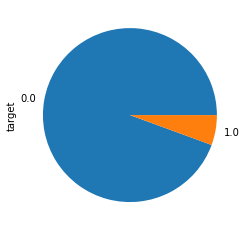

In [ ]:
#repartion des classes 
client_train['target'].value_counts(True).plot.pie() # on peut noter que les données sont trop  desequilibrer 

In [ ]:
#les variables de type int dans le client
for col in client_train.select_dtypes('int64'):
    print(f'{col}----------------------',client_train[col].unique())

disrict---------------------- [60 69 62 63]
client_catg---------------------- [11 12 51]
region---------------------- [101 107 301 105 303 103 309 311 304 104 312 305 306 308 372 307 313 310
 371 302 106 379 399 206 199]


In [ ]:
#les variables de type int dans le invoice
for col in invoice_train.select_dtypes('int64'):
    print(f'{col}----------------------',invoice_train[col].unique())

tarif_type---------------------- [11 40 15 10 12 14 13 45 29  9 30  8 21 42 27 18 24]
counter_number---------------------- [1335667  678902  572765 ... 4811719  262195  560948]
counter_code---------------------- [203 207 413   5 467 202 420 410  10 483  25 433 407 204 214 442 453 506
 450 403 333 201 102 305 210 101 532  40 310 565 600 307 303 222  65   0
 227 325  16 317 367   1]
reading_remarque---------------------- [  8   6   9   7 207 413 203   5]
counter_coefficient---------------------- [ 1  3  0 10  4 33 50 20  2  6 40  9 30  5 11  8]
consommation_level_1---------------------- [   82  1200   123 ... 43053  4824  8314]
consommation_level_2---------------------- [    0   184   186 ... 46017 29019 32001]
consommation_level_3---------------------- [   0  800   43 ... 1710 1750 1390]
consommation_level_4---------------------- [    0   382   132 ...  8613  8859 12645]
old_index---------------------- [ 14302  12294  14624 ... 141551 110850  86004]
new_index---------------------- [ 143

In [ ]:
##les categories de type object dans le client
for col in invoice_train.select_dtypes('object'):
    print(f'{col}----------------------',invoice_train[col].unique())

client_id---------------------- ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999']
invoice_date---------------------- ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02']
counter_statue---------------------- [0 1 5 4 3 2 769 '0' '5' '1' '4' 'A' 618 269375 46 420]
counter_type---------------------- ['ELEC' 'GAZ']


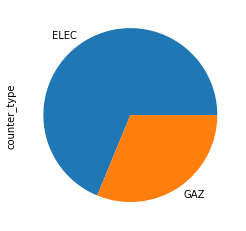

In [ ]:
#repartition des types de compteurs 
invoice_train['counter_type'].value_counts(True).plot.pie()

# PRE_PROCESSING

In [ ]:
#fonction Merger le invoice et le client
def merge_data (invoice, client) : 

  return invoice.merge(client)


#suppression des valeurs aberantes
def supp_Vl_aberantes (dataset) : 

    iso = IsolationForest()
    iso.fit(dataset.select_dtypes('int64'))
    iso_array = iso.predict(dataset.select_dtypes('int64'))
    dataset[iso_array==-1]['target'].value_counts()
    dataset = dataset[iso_array==1]
    
    return dataset


#undersampling function
def under_sampling (data) :
  iso = IsolationForest()
  for i in range(5): 
    iso.fit(data.select_dtypes('int64'))
    iso_array = iso.predict(data.select_dtypes('int64'))
    data = data[iso_array==1]

  return data    


#padding function
def pad_lot(lot_facts, seuil):

    #si le nombre de factures est superieur au seuil on ecarte le reste 
    if len(lot_facts) >= seuil:
        lot_facts_padded = lot_facts.iloc[:seuil, :]

    # si non on complete par la derniere facture pour atteindre le seuil
    else:
        #On calcul l'ecart entre le seuil et la taille du lot
        ecart = seuil - len(lot_facts)
        ecart_df = pd.DataFrame([lot_facts.iloc[-1]]*ecart)
        #On concat lot_fact et le dataframe contenant uniquement la derniere facture de lot_fact ecart fois 
        lot_facts_padded = pd.concat([lot_facts, ecart_df], ignore_index=True)
      
    return lot_facts_padded



#fonction qui met dans une liste tous les lots de factures du dataset
def lister_dataset_padded (data, nb_factures) :
  depart=0
  list_facts= []
  for nb in range(len(data.groupby('client_id'))) :
    list_facts.append(data.iloc[depart:depart + nb_factures,:].drop('client_id', axis=1))
    depart = depart + nb_factures

  return list_facts 
  

In [ ]:
def pre_processing (invoice , client) : 

#merger le invoice et le client
  dataset = merge_data(invoice, client)

#suppression des valeurs aberantes
  dataset = supp_Vl_aberantes(dataset)

# division de la base par classe
  class_0 = dataset[dataset['target']==0].reset_index(drop=True)
  class_1 = dataset[dataset['target']==1].reset_index(drop=True)

#undersampling sur la classe 0
  class_0 = under_sampling(class_0)

#concatenons class_0 et class_1
  dataset =pd.concat([class_0,class_1], ignore_index=True)
  
#rangement des factures par client_id et invoice_date
  dataset = dataset.sort_values(by=['client_id','invoice_date'], ignore_index=True)

# selection de variables 
  cols = ['client_id','tarif_type','counter_coefficient','consommation_level_1','consommation_level_2',
          'consommation_level_3','consommation_level_4','old_index','new_index','months_number','target']
  data = dataset[cols] 
  

#padding data
  dataset_padded = data.groupby('client_id').apply(pad_lot, 100).reset_index(drop=True)

#colonne a standardiser et colonnes à categoriser
  col_to_scaling = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4','new_index','old_index','months_number']
  col_cat = ['tarif_type','counter_coefficient']

#rendre categorielle les colonnes et rendre numerique ensuite
  dataset_padded[col_cat] = dataset_padded[col_cat].astype('category')
  dataset_padded = pd.get_dummies(dataset_padded, columns=col_cat, drop_first=True)

#standardiser les variables continues
  std = StandardScaler()
  dataset_padded[col_to_scaling]=std.fit_transform(dataset_padded[col_to_scaling])

#recuperation de la target
  client = client.set_index(client['client_id']).drop('client_id',axis=1)
  target = client.loc[list(dataset_padded.client_id.unique())].target
  dataset_padded.drop(['target'],axis=1, inplace=True)
  print(dataset_padded.shape)

#lister_lot sur dataset_padded
  dataset_padded_list = lister_dataset_padded(dataset_padded,100)
 

#transformer en numpy array la liste des sequences de 100 factures
  label = np.asarray(target)
  data_clean = np.asarray(dataset_padded_list)
  

  return data_clean, label

   

In [ ]:
data_clean , label = pre_processing(invoice_train, client_train)

(7719900, 23)


# MODELISATION

In [ ]:
#Import package
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

#Instaciation du model
def my_model (input_shape) :
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))
  model.add(tf.keras.layers.LSTM(100))
  model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2()))
  model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2()))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2()))
  #Compilation du model
  model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc',tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
  return model
    

#fonction de prediction
def y_predict (model, X_val):
  y_pred = []
  for m in model.predict(X_val) : 
    if  m[0] > .5 :
      y_pred.append(1)
    else : 
        y_pred.append(0)
  return np.asarray(y_pred) 



# Definir les callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]



#Entrainement et Evaluation du model
def evaluation (model) : 
    
    history = model.fit(X_train,y_train, epochs=100, validation_split=.2, batch_size=128, class_weight={0:1, 1:nb_0s//nb_1s},callbacks=callbacks)
    y_pred = y_predict(model, X_val)
    
    print (confusion_matrix(y_val,y_pred))
    print( classification_report(y_val,y_pred))

    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for false_negatives
    plt.plot(history.history['false_negatives_2'])
    plt.plot(history.history['val_false_negatives_2'])
    plt.title('model false_negatives')
    plt.ylabel('false_negatives')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for false_positives
    plt.plot(history.history['false_positives_2'])
    plt.plot(history.history['val_false_positives_2'])
    plt.title('model false_positives')
    plt.ylabel('false_positives')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()




#APPLICATIONS

In [ ]:
X_train, X_val , y_train, y_val = train_test_split(data_clean, label, test_size=.2, random_state=42)

# equilibrage des classes
nb_1s = sum(label)
nb_0s = len(label) - nb_1s

Epoch 1/100
361/361 [==============================] - 53s 141ms/step - loss: 1.5266 - acc: 0.8260 - false_positives_2: 3042.5083 - false_negatives_2: 511.2376 - val_loss: 0.5975 - val_acc: 0.9131 - val_false_positives_2: 610.0000 - val_false_negatives_2: 392.0000
Epoch 2/100
361/361 [==============================] - 50s 139ms/step - loss: 0.8699 - acc: 0.8676 - false_positives_2: 2401.3066 - false_negatives_2: 610.0580 - val_loss: 0.2813 - val_acc: 0.9518 - val_false_positives_2: 281.0000 - val_false_negatives_2: 275.0000
Epoch 3/100
361/361 [==============================] - 50s 138ms/step - loss: 0.5369 - acc: 0.9309 - false_positives_2: 1278.9724 - false_negatives_2: 302.5166 - val_loss: 0.2067 - val_acc: 0.9721 - val_false_positives_2: 207.0000 - val_false_negatives_2: 114.0000
Epoch 4/100
361/361 [==============================] - 50s 139ms/step - loss: 0.3981 - acc: 0.9626 - false_positives_2: 625.7044 - false_negatives_2: 214.7017 - val_loss: 0.1375 - val_acc: 0.9820 - val_fal

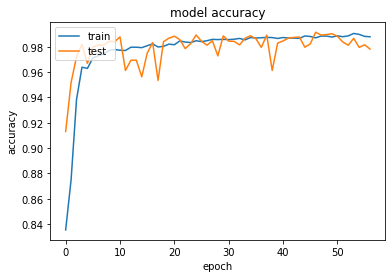

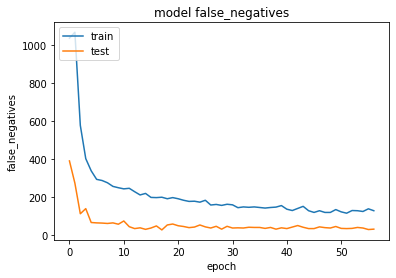

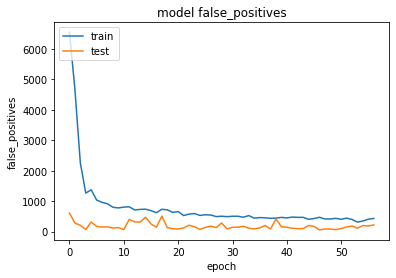

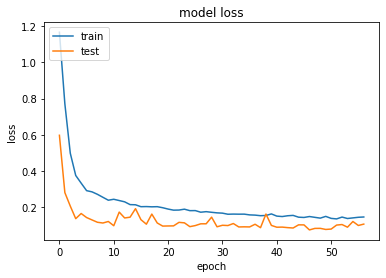

In [ ]:
model = my_model((data_clean.shape[1], data_clean.shape[2]))
evaluation(model)

In [ ]:
tf.__version__, np.__version__, pd.__version__

('2.4.1', '1.19.5', '1.1.5')